In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]


generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]

raw = load_mm94_stations(train_station_id + test_station_id + generate_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis, interpol_freq=20)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_air', ))

del data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY], data[MmxColumns.ID_ROAD_TEMPERATURE]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

generated = data[data['station_id'].isin(generate_station_id)]
generated = generated.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 2min 14s, sys: 15 s, total: 2min 29s
Wall time: 2min 33s


## Feature selection

In [3]:
from preprocessing import create_feature_df
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from functools import partial

In [4]:
point = pd.Timestamp(2015, 6, 1)

params_df = {}  
params_df['target'] = 'data_t_air'
params_df['variables'] = ['data_t_air', 'data_t_road', 'data_t_underroad', 
                          'data_pressure', 'data_dampness']
params_df['interpol_freq'] = 20
params_df['lag_list'] = (1, 2, 3, 4, 5, 6, 7, 8)
params_df['diff_list'] = ((1, 2), (2, 3), (3, 4), (4, 5), (5, 6))
params_df['coordinates'] = True
params_df['solar_angles'] = True
params_df['road_id'] = False
params_df['day_of_year'] = True
params_df['month'] = False
params_df['hour'] = True
params_df['post_process'] = False

df_train = create_feature_df(train[train['date_time_utc'] < point], **params_df)
df_valid = create_feature_df(train[train['date_time_utc'] >= point], **params_df)
df_test = create_feature_df(test, **params_df)

In [5]:
main_cols = ('data_t_road', 'data_t_air', 'data_t_underroad', 'data_pressure', 'data_humidity')
features = [col for col in df_train if col.startswith('data_')]
features = [col for col in features if col not in (main_cols)]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values)

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values)

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values)

lgb_train = lgb.Dataset(X_train, y_train, feature_name=features)
lgb_val = lgb.Dataset(X_valid, y_valid, reference=lgb_train, feature_name=features)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, feature_name=features)

## Train model

In [6]:
baseline_mse = mean_squared_error(df_train.data_t_air_lag_20, df_train.target_t_air)
baseline_mae = mean_absolute_error(df_train.data_t_air_lag_20, df_train.target_t_air)

print('MAE: {0: .2f} \nMSE: {1: .2f}'.format(baseline_mae, baseline_mse))

MAE:  0.23 
MSE:  0.14


In [7]:
#	train's l1: 0.114561	valid's l1: 0.117564	test's l1: 0.129071

In [8]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l1',
    'num_leaves': 65,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'lambda_l1': 1.0,
    'lambda_l2': 2.0,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=(lgb_train, lgb_val, lgb_test),
                valid_names=('train', 'valid', 'test'),
                verbose_eval=200,)

[200]	train's l1: 0.13832	valid's l1: 0.126982	test's l1: 0.142398
[400]	train's l1: 0.125146	valid's l1: 0.118538	test's l1: 0.131146
[600]	train's l1: 0.119429	valid's l1: 0.115197	test's l1: 0.126716
[800]	train's l1: 0.115542	valid's l1: 0.112881	test's l1: 0.123686
[1000]	train's l1: 0.112892	valid's l1: 0.111449	test's l1: 0.121812
[1200]	train's l1: 0.110823	valid's l1: 0.110386	test's l1: 0.120424
[1400]	train's l1: 0.109111	valid's l1: 0.109547	test's l1: 0.119295
[1600]	train's l1: 0.107606	valid's l1: 0.108929	test's l1: 0.118428
[1800]	train's l1: 0.106334	valid's l1: 0.108419	test's l1: 0.117738
[2000]	train's l1: 0.105184	valid's l1: 0.108011	test's l1: 0.117134
[2200]	train's l1: 0.10408	valid's l1: 0.10756	test's l1: 0.116522
[2400]	train's l1: 0.103079	valid's l1: 0.107209	test's l1: 0.116058
[2600]	train's l1: 0.102206	valid's l1: 0.106919	test's l1: 0.115671
[2800]	train's l1: 0.101284	valid's l1: 0.106595	test's l1: 0.115234
[3000]	train's l1: 0.100438	valid's l1: 0

In [11]:
z = list(zip(features, list(gbm.feature_importance())))
z.sort(key=lambda item: item[1], reverse=True)
z[:5]

[('data_dampness', 14764),
 ('data_t_air_diff_20_40', 14048),
 ('data_dampness_lag_20', 11074),
 ('data_t_air_diff_40_60', 10621),
 ('data_dampness_diff_20_40', 9227)]

## Save Model

import pickle

f = open('/mnt/HARD/MinMax94/models/anomaly_detection/detector_t_air.pickle','wb')                                                                                                                                                                                                                                                           
pickle.dump(gbm,f)                                                                                                                                                                                                                                                                        
f.close()

## Select Threshold

### Generate anomalies

In [11]:
from score import calc_precision, calc_recall, calc_f1_score
from generate_anomalies import generate_single_anomaly, generate_short_term_anomaly, generate_long_term_anomaly

np.random.seed(42)
to_generate = copy(generated)
to_generate['label_true'] = False
col = MmxColumns.AIR_TEMPERATURE

#---------------------------------------------------------------------------------
number_of_anomalies = 30 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_single_anomaly(to_generate, index)
    to_generate.loc[index, col] += perturbated_series
    to_generate.loc[index, 'label_true'] = True
    
#---------------------------------------------------------------------------------
number_of_anomalies = 20 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_short_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

#---------------------------------------------------------------------------------
number_of_anomalies = 3 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_long_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

### Obtain anomaly scores

In [12]:
df_generate = create_feature_df(to_generate, **params_df)

X_generate = np.array(df_generate[features].values)
y_generate = np.array(df_generate[target].values)
lgb_generate = lgb.Dataset(X_generate, y_generate, reference=lgb_train, feature_name=features)
y_gen_pred = gbm.predict(X_generate)

df = copy(df_generate[['label_true', 'station_id', 'date_time_utc', 'target_t_air']])
df['decision_function'] = np.abs(y_gen_pred - y_generate)

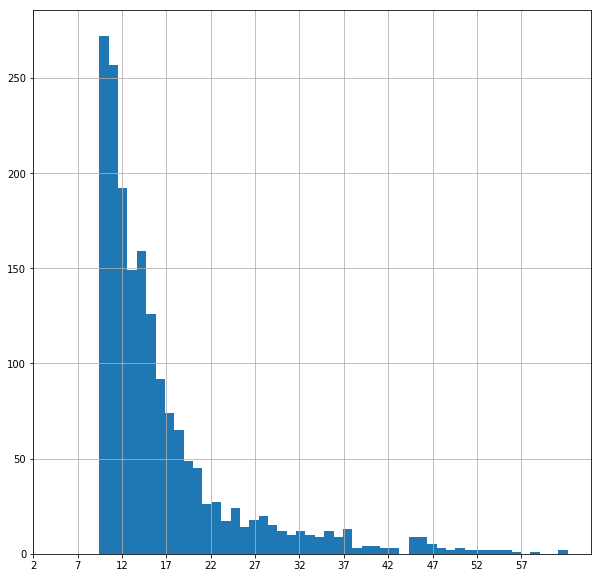

In [33]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))
hist = df['decision_function'].nlargest(len(df) // 500)
plt.hist(hist, bins=50)
plt.grid()
plt.xticks(np.arange(2, 60, 5))
plt.show()

### Select optimal threshold

In [41]:
st_id = generate_station_id
window = pd.Timedelta('4h')
generated_results = []

for thresh in np.arange(5, 7, 0.2):
    df['label_predict'] = df['decision_function'] > thresh
        
    recall = calc_recall(df, st_id, window)
    precision = calc_precision(df, st_id, window)
    f1 = calc_f1_score(precision, recall)
    
    generated_results.append({'Threshold': thresh, 'F1': f1 ,'Recall': recall, 'Precision': precision,})
    print("Threshhold: {0:.3f} -- {1:.3f}, {2:.3f}, {3:.3f}".format(thresh, f1, recall, precision))
    
## 6.800

Threshhold: 5.000 -- 0.886, 0.982, 0.806
Threshhold: 5.200 -- 0.887, 0.982, 0.809
Threshhold: 5.400 -- 0.889, 0.980, 0.813
Threshhold: 5.600 -- 0.889, 0.977, 0.816
Threshhold: 5.800 -- 0.890, 0.975, 0.819
Threshhold: 6.000 -- 0.891, 0.973, 0.822
Threshhold: 6.200 -- 0.894, 0.971, 0.827
Threshhold: 6.400 -- 0.896, 0.970, 0.832
Threshhold: 6.600 -- 0.897, 0.968, 0.835
Threshhold: 6.800 -- 0.898, 0.966, 0.839


## Predict values

In [42]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)

## Decision Function

In [70]:
threshold = 2
df_train['predict_t_air'] = y_train_pred
df_train['label_predict'] = np.abs(y_train - y_train_pred) > threshold
num_of_outliers = len(df_train[df_train['label_predict']])
percentage = num_of_outliers / len(df_train)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_train)))
print(df_train.groupby('station_id')['label_predict'].sum())

Ratio of anomalies is 0.00017% (283 out of 1629577)
station_id
113       3.0
115       6.0
116       2.0
118      10.0
126      11.0
150      14.0
152       2.0
200       1.0
223       8.0
228      37.0
239      12.0
305       1.0
308       4.0
309      44.0
401       8.0
411       7.0
432      22.0
435       6.0
454      13.0
456      28.0
593       4.0
628       3.0
1831     11.0
1899      3.0
1911      2.0
1921      3.0
4007      3.0
20323     1.0
20717     4.0
20743     1.0
20754     0.0
20755     0.0
20761     3.0
20916     1.0
20921     5.0
Name: label_predict, dtype: float64


In [60]:
threshold = 2
df_test['predict_t_air'] = y_pred
df_test['label_predict'] = np.abs(y_test - y_pred) > threshold
num_of_outliers = len(df_test[df_test['label_predict']])
percentage = num_of_outliers / len(df_test)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_test)))
print(df_test.groupby('station_id')['label_predict'].sum())

Ratio of anomalies is 0.00077% (720 out of 935551)
station_id
114      42.0
117      49.0
119     130.0
302      30.0
303      18.0
307      57.0
393      43.0
442      16.0
503      22.0
504     108.0
511      15.0
516       8.0
1838    117.0
1896     65.0
Name: label_predict, dtype: float64


## Plot result

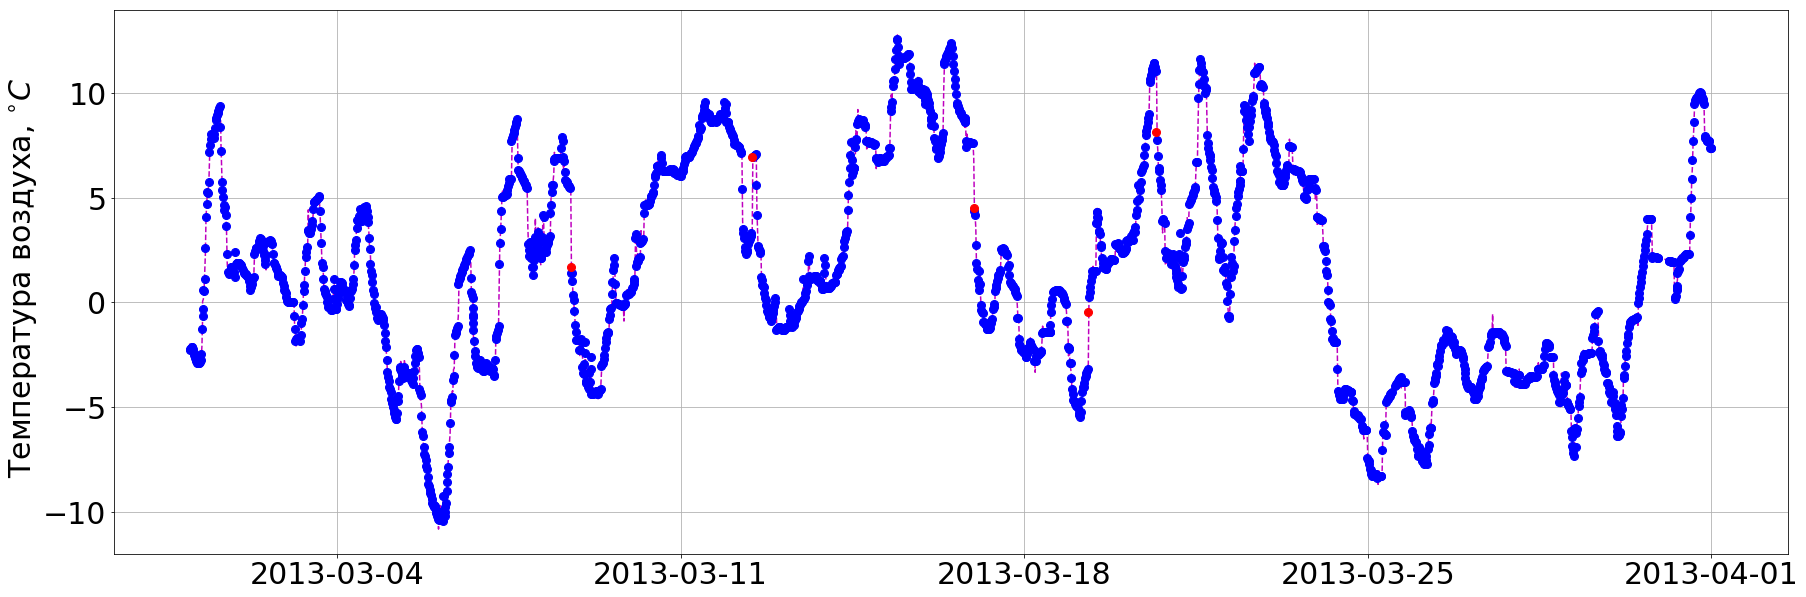

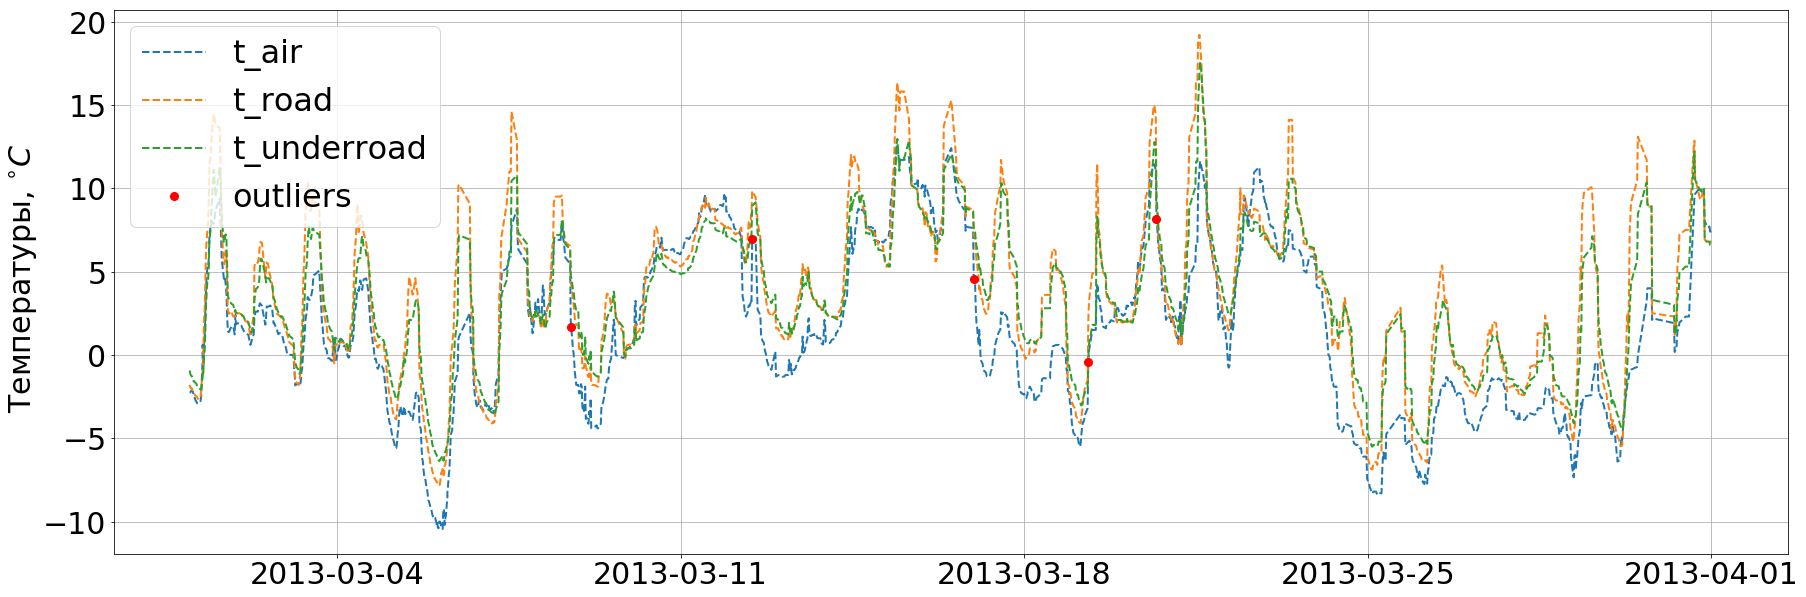

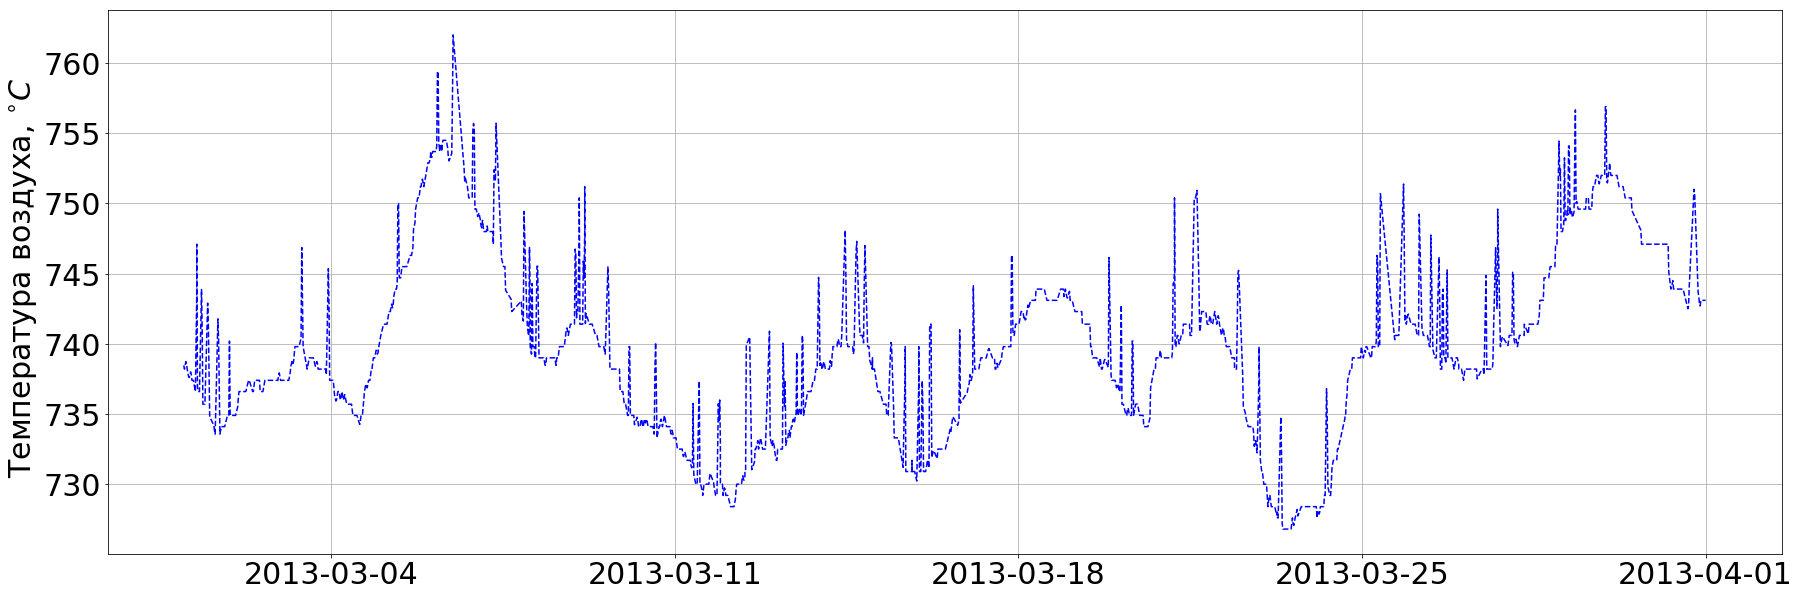

In [76]:
import matplotlib.pyplot as plt

#####-----------------------------STATION_ID-------------------------------#####
#z = copy(df_test[df_test['station_id']==119].set_index('date_time_utc'))
z = copy(df_train[df_train['station_id']==456].set_index('date_time_utc'))

#####-----------------------------TIME_INTERVAL-------------------------------#####
start = pd.Timestamp(2013, 3, 1)
end = pd.Timestamp(2013, 4, 1)
to_plot = z[(z.index<=end) & (z.index>=start)]

#####-----------------------------T_AIR-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['predict_t_air'], 'm',
                      linestyle='--', marker='None', markersize=8, label='predicted T_air')

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_air'], 'b',
                      linestyle='none', marker='o', markersize=8, label='true T_air')
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_air'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Температура воздуха, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)


#####-----------------------------TEMPERATURE-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['target_t_air'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_air')
        
        plt.plot_date(to_plot.index, to_plot['data_t_road'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_road')
        
        plt.plot_date(to_plot.index, to_plot['data_t_underroad'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_underroad')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_air'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температуры, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)

#####-----------------------------T_AIR-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['data_pressure'], 'b',
                      linestyle='--', marker='None', markersize=8, label='pressure')


plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Температура воздуха, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)

plt.show()